In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

### Conv2D 적용하기
* Conv2D() 를 모델에 적용 시에는 반드시 입력은 배치 크기를 제외하고 3차원이 되어야 함(즉 배치를 포함하면 4차원)  

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_tensor = Input(shape=(28, 28, 1)) # (행, 열, 차원) (GrayScale일 경우 차원 1, RGB일 경우 차원 3)
x = Conv2D(filters=4, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor) # 커널 사이즈는 3 x 3, filter는 여러개의 kernel이므로 3차원 filters는 4차원, kernel의 개숫는 input data의 차원 수와 자동으로 맞춰짐
print('x type:', type(x), 'x:', x)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

x type: <class 'keras.engine.keras_tensor.KerasTensor'> x: KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 4), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")


### Pooling 적용하기

In [3]:
input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor) # element wise 연산 뒤 activation까지 적용하면 Feature Map이 나옴
x = MaxPooling2D(2)(x) # 2 x 2의 pooling size 선택
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 16), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")


### CNN 모델 생성

In [4]:
input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x) 

model = Model(inputs=input_tensor, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [5]:
from tensorflow.keras.layers import Dense, Flatten

input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

# 3차원으로 되어있는 Feature map 결과를 Fully Connected 연결하기 위해서는 Flatten()을 적용해야함. 
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 100)               1081700   
                                                           

### Fashion MNIST 데이터 전처리후 모델 학습

In [6]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 전체 6만개 데이터 중, 5만개는 학습 데이터용, 1만개는 테스트 데이터용으로 분리
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

def get_preprocessed_data(images, labels):
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# Fashion MNIST 데이터 재 로딩 및 전처리 적용하여 학습/검증/데이터 세트 생성. 

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_labels.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(51000, 28, 28) (51000, 10) (9000, 28, 28) (9000, 10) (10000, 28, 28) (10000,)


In [7]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
399/399 [==============================] - 11s 7ms/step - loss: 0.4514 - accuracy: 0.8389 - val_loss: 0.3436 - val_accuracy: 0.8717
Epoch 2/30
399/399 [==============================] - 2s 6ms/step - loss: 0.2805 - accuracy: 0.8987 - val_loss: 0.2762 - val_accuracy: 0.9026
Epoch 3/30
399/399 [==============================] - 2s 6ms/step - loss: 0.2274 - accuracy: 0.9176 - val_loss: 0.2430 - val_accuracy: 0.9144
Epoch 4/30
399/399 [==============================] - 3s 6ms/step - loss: 0.1917 - accuracy: 0.9287 - val_loss: 0.2396 - val_accuracy: 0.9170
Epoch 5/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1593 - accuracy: 0.9406 - val_loss: 0.2452 - val_accuracy: 0.9151
Epoch 6/30
399/399 [==============================] - 3s 6ms/step - loss: 0.1339 - accuracy: 0.9494 - val_loss: 0.2524 - val_accuracy: 0.9149
Epoch 7/30
399/399 [==============================] - 3s 6ms/step - loss: 0.1107 - accuracy: 0.9595 - val_loss: 0.2871 - val_accuracy: 0.9119
Epoch

### 모델 성능 평가

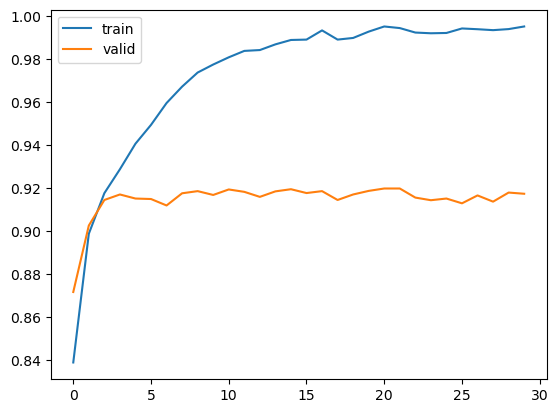

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [10]:
# 테스트 데이터 세트로 모델 성능 검증
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 6ms/step - loss: 0.8423 - accuracy: 0.9108


[0.8423370122909546, 0.9107999801635742]

### Dropout을 적용하여 Fully Connected Layer의 오버피팅 조정
* CNN은 일반적으로 Dense Layer보다는 파라미터수(weight 수) 작음
* 하지만 많은 Filter 들을 적용하고 이를  Fully Connected Layer로 연결 시 파라미터 수가 늘어남. Dense Layer에서 파라미터의 수가 급격히 증가하므로 오버피팅의 가능성이 증거함 
* Flatten() 이후 Dropout을 적용하여 특정 비율로 FC Layer 연결을 누락 적용. 
* Dropout은 Dense Layer에서 모든 뉴련을 연결시키지 않고, 몇몇의 뉴런을 연결시키지 않는 것이다.

In [11]:
from tensorflow.keras.layers import Dense, Flatten, Dropout

input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x) # 50% 뉴런의 연결을 막음
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)             0         
                                                           

In [12]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
399/399 [==============================] - 4s 7ms/step - loss: 0.4522 - accuracy: 0.8397 - val_loss: 0.3327 - val_accuracy: 0.8830
Epoch 2/30
399/399 [==============================] - 3s 6ms/step - loss: 0.2990 - accuracy: 0.8902 - val_loss: 0.2860 - val_accuracy: 0.8961
Epoch 3/30
399/399 [==============================] - 2s 6ms/step - loss: 0.2487 - accuracy: 0.9080 - val_loss: 0.2497 - val_accuracy: 0.9096
Epoch 4/30
399/399 [==============================] - 3s 6ms/step - loss: 0.2138 - accuracy: 0.9207 - val_loss: 0.2394 - val_accuracy: 0.9139
Epoch 5/30
399/399 [==============================] - 3s 6ms/step - loss: 0.1894 - accuracy: 0.9286 - val_loss: 0.2275 - val_accuracy: 0.9188
Epoch 6/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1687 - accuracy: 0.9355 - val_loss: 0.2281 - val_accuracy: 0.9198
Epoch 7/30
399/399 [==============================] - 3s 6ms/step - loss: 0.1510 - accuracy: 0.9427 - val_loss: 0.2382 - val_accuracy: 0.9208
Epoch 

40/40 [==============================] - 0s 4ms/step - loss: 0.5165 - accuracy: 0.9130


[0.516473114490509, 0.9129999876022339]

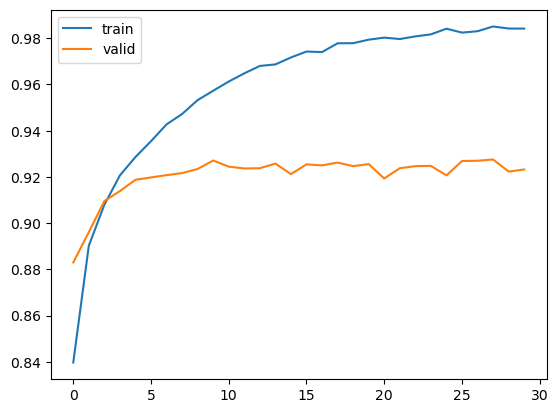

In [13]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

In [14]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

def create_model():
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)

    #x = Dropout(rate=0.5)(x)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu')(x)
    X = Dropout(rate=0.2)(x) # Dropout을 두번 적용
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

model = create_model()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_1 (Dropout)         (None, 10816)             0         
                                                           

In [15]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
399/399 [==============================] - 5s 7ms/step - loss: 0.4310 - accuracy: 0.8463 - val_loss: 0.3093 - val_accuracy: 0.8864
Epoch 2/30
399/399 [==============================] - 3s 7ms/step - loss: 0.2797 - accuracy: 0.8971 - val_loss: 0.2606 - val_accuracy: 0.9058
Epoch 3/30
399/399 [==============================] - 3s 7ms/step - loss: 0.2294 - accuracy: 0.9153 - val_loss: 0.2355 - val_accuracy: 0.9150
Epoch 4/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1954 - accuracy: 0.9262 - val_loss: 0.2218 - val_accuracy: 0.9202
Epoch 5/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1681 - accuracy: 0.9366 - val_loss: 0.2379 - val_accuracy: 0.9184
Epoch 6/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1479 - accuracy: 0.9434 - val_loss: 0.2367 - val_accuracy: 0.9212
Epoch 7/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1266 - accuracy: 0.9525 - val_loss: 0.2348 - val_accuracy: 0.9227
Epoch 

40/40 [==============================] - 0s 4ms/step - loss: 0.5623 - accuracy: 0.9184


[0.562341570854187, 0.91839998960495]

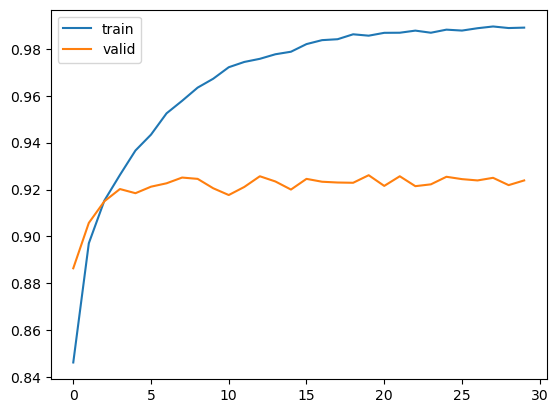

In [16]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

### 입력 이미지는 배치를 포함하여 4차원이 되어야 함(즉 배치를 제외하면 3차원)
* Conv2D()는 입력으로 배치를 제외하고 3차원 입력이 되어야 함. 
* 하지만 2차원으로 입력해도 Input(shape=(28, 28, 1)) 에서 3차원으로 변경함. 
* 명확하게는 2차원 Grayscale이미지더라도 입력 numpy 이미지 배열에서 배치를 제외한 3차원 입력을 만들어 주는게 좋음. 

In [17]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print('before reshape:', train_images.shape, test_images.shape)
train_images = np.reshape(train_images, (60000, 28, 28, 1))
test_images = np.reshape(test_images, (10000, 28, 28, 1))
print('after reshape:', train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_labels.shape)

before reshape: (60000, 28, 28) (10000, 28, 28)
after reshape: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)
(51000, 28, 28, 1) (51000, 10) (9000, 28, 28, 1) (9000, 10) (10000, 28, 28, 1) (10000,)


In [18]:
from tensorflow.keras.optimizers import Adam

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_3 (Dropout)         (None, 10816)             0         
                                                           

40/40 [==============================] - 0s 6ms/step - loss: 0.5664 - accuracy: 0.9159


[0.566417396068573, 0.9158999919891357]

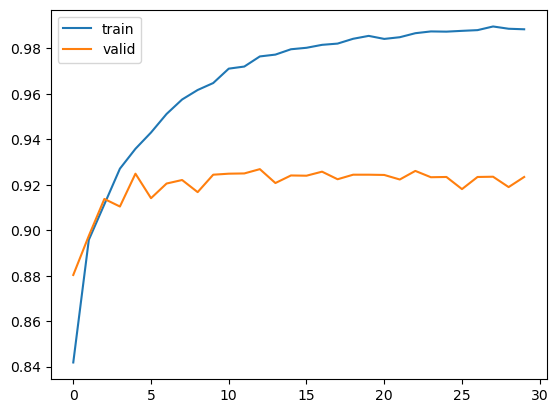

In [19]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

### Stride가 1이고 Padding이 없는 경우
* I는 입력 Feature Map의 크기, F는 Filter의 크기(Kernel size), P는 Padding(정수), S는 Strides(정수)
* O = (I - F + 2P)/s + 1 = (5 - 3 + 0 )/1 + 1 = 3

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_tensor = Input(shape=(5, 5, 1))
x = Conv2D(filters=1, kernel_size=3, strides=1)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


### Stride가 1이고 Padding이 1인 경우
* O = (I - F + 2P)/2 + 1 = (5 - 3 + 2 )/1 + 1 = 5

In [21]:
input_tensor = Input(shape=(5, 5, 1))
x = Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 5, 5, 1)


In [22]:
# ZeroPadding2D Layer를 이용하여 padding을 수동으로 적용. 
from tensorflow.keras.layers import ZeroPadding2D

input_tensor = Input(shape=(5, 5, 1))
padded_input = ZeroPadding2D(padding=1)(input_tensor)
print('shape after padding:', padded_input.shape)
x = Conv2D(filters=1, kernel_size=3, strides=1)(padded_input)
print('x.shape:', x.shape)


shape after padding: (None, 7, 7, 1)
x.shape: (None, 5, 5, 1)


### Stride가 2이고 Padding이 없는 경우 
* O = (I - F + 2P)/2 + 1 = (5 - 3)/2 + 1 = 2

In [23]:
input_tensor = Input(shape=(5, 5, 1))
x = Conv2D(filters=1, kernel_size=3, strides=2)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 2, 2, 1)


### Stride가 2이고 Padding은 1 적용
* O = (I - F + 2P)/2 + 1 = (5 - 3 + 2)/2 + 1 = 3

In [24]:
input_tensor = Input(shape=(5, 5, 1))
padded_input = ZeroPadding2D(padding=1)(input_tensor)
print('shape after padding:', padded_input.shape)
x = Conv2D(filters=1, kernel_size=3, strides=2)(padded_input)
print('x.shape:', x.shape)

shape after padding: (None, 7, 7, 1)
x.shape: (None, 3, 3, 1)


### 입력이 6X6에서 Stride가 2 적용
* O = (I - F + 2P)/2 + 1 = (6 - 3 + 0)/2 + 1 = 2.5 = 2 

In [25]:
input_tensor = Input(shape=(6, 6, 1))
x = Conv2D(filters=1, kernel_size=3, strides=2)(input_tensor)
print('x.shape:', x.shape)

x.shape: (None, 2, 2, 1)


In [26]:
input_tensor = Input(shape=(6, 6, 1))
x = Conv2D(filters=1, kernel_size=3, strides=2, padding='same')(input_tensor) (but kernel size와 같은 3 x 3 아웃풋이 출력된다.)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


In [27]:
input_tensor = Input(shape=(6, 6, 1))
padded_input = ZeroPadding2D(padding=1)(input_tensor)
x = Conv2D(filters=1, kernel_size=3, strides=2, padding='valid')(padded_input)
print('x.shape:', x.shape)

x.shape: (None, 3, 3, 1)


In [1]:
input_tensor = Input(shape=(6, 6, 1))
padded_input = ZeroPadding2D(padding=((1, 0),(1,0)))(input_tensor) # 위만 패딩, 아래쪽만 패딩
x = Conv2D(filters=1, kernel_size=3, strides=2)(padded_input)
print('x.shape:', x.shape)

NameError: name 'Input' is not defined

### Maxpooling 적용

In [29]:
input_tensor = Input(shape=(223, 223, 1))
x = MaxPooling2D(2)(input_tensor) # 이것도 소숫점을 없애버림
print('x.shape:', x.shape)

x.shape: (None, 111, 111, 1)
